In [1]:
from math import sqrt

import numpy as np

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import skimage
from skimage import io, exposure, img_as_float, img_as_ubyte, morphology, filters, util
from skimage.color import rgb2gray, label2rgb
from skimage.feature import canny, blob_dog, blob_log, blob_doh,  peak_local_max
from skimage.filters import sobel, threshold_otsu, try_all_threshold, threshold_local, threshold_minimum
from skimage.segmentation import clear_border, watershed, random_walker
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

from scipy import ndimage as ndi

import os

import plotly.graph_objs as go

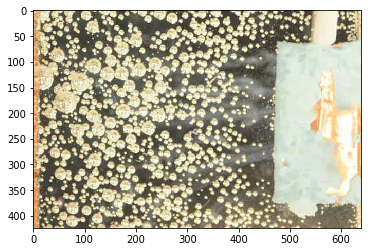

In [2]:
f = io.imread('sample-images/prefreeze_bubbles.png')
plt.figure(0)
plt.imshow(f)

(424, 640)

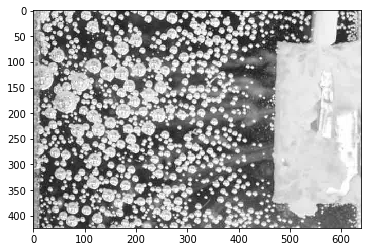

In [3]:
f_grey = rgb2gray(f)
plt.figure(1)
plt.imshow(f_grey, cmap=plt.cm.gray)
f_grey.shape

/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning:

Possible precision loss when converting from float64 to uint8



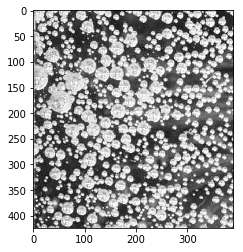

In [4]:
f_cropped = f_grey[:,10:400]
f_uint = img_as_ubyte(f_cropped)
plt.figure(2)
plt.imshow(f_uint, cmap=plt.cm.gray)

Otsu threshold: 154
Min intensity: 30
Max intensity: 255


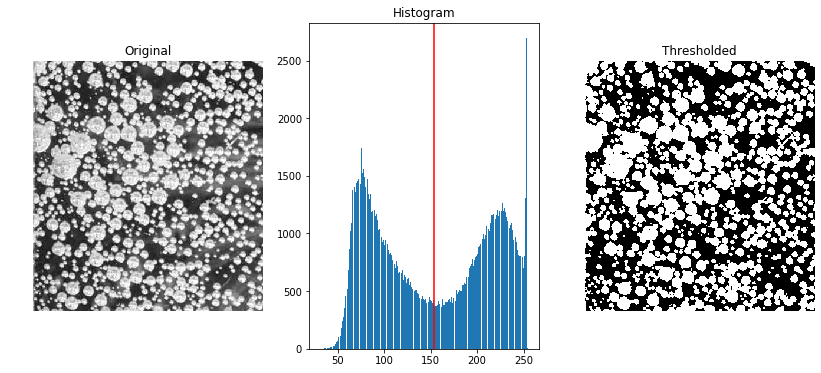

In [5]:
image = f_uint

thresh = threshold_otsu(image)
binary = image > thresh

fig, axes = plt.subplots(ncols=3, figsize=(14, 6))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

print('Otsu threshold: ' + str(thresh))
print('Min intensity: ' + str(np.min(image)))
print('Max intensity: ' + str(np.max(image)))
plt.show()

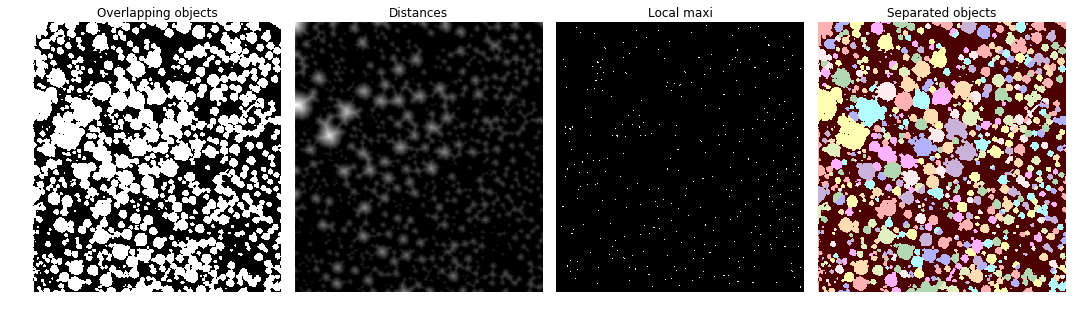

Number of maximas: 609
Number of regions: 607


In [10]:
image = binary
closed = closing(binary)
distance = ndi.distance_transform_edt(closed)

cont_stretch = exposure.rescale_intensity(distance, in_range='image')

local_maxi = peak_local_max(cont_stretch, indices=False, footprint=np.ones((10, 10)))
markers, num_max = ndi.label(local_maxi)
segmented = watershed(-cont_stretch, markers, mask = image, watershed_line=True)

labeled, num_sec = ndi.label(segmented)

image_label_overlay = label2rgb(labeled, image=image)

fig, axes = plt.subplots(ncols=4, figsize=(15, 6), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Overlapping objects')
ax[1].imshow(cont_stretch, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Distances')
ax[2].imshow(local_maxi, cmap=plt.cm.gray, interpolation='nearest')
ax[2].set_title('Local maxi')
ax[3].imshow(image_label_overlay, interpolation='nearest')
ax[3].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

print('Number of maximas: ' + str(num_max))
print('Number of regions: ' + str(num_sec))

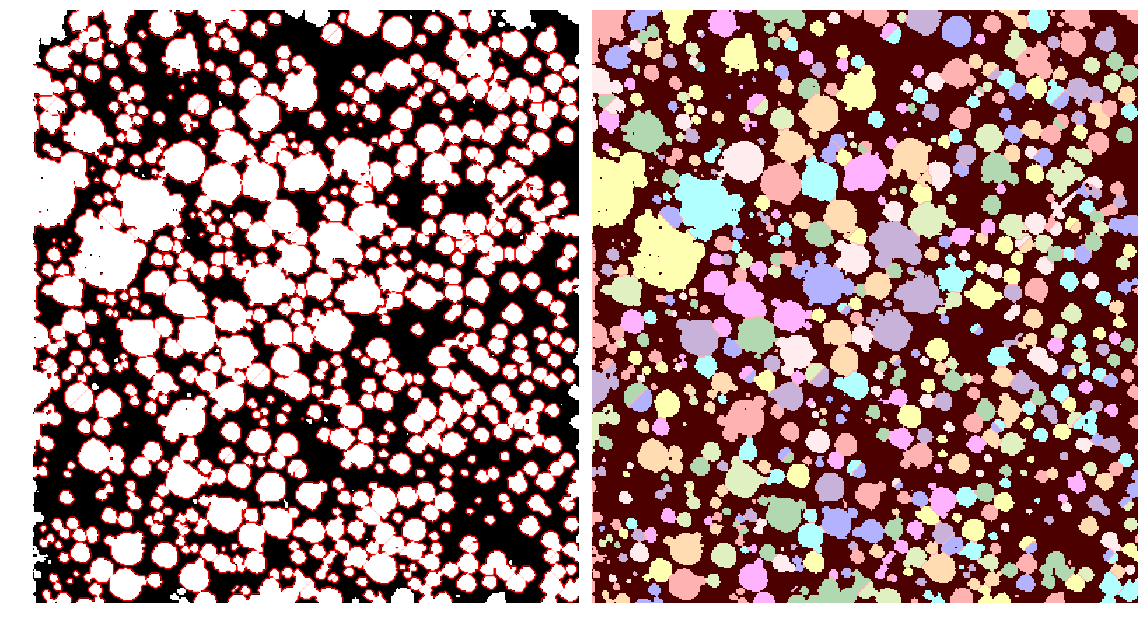

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 10), sharey=True)
axes[0].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
axes[0].contour(segmented, [0.5], linewidths=1.2, colors='r')
axes[1].imshow(image_label_overlay, interpolation='nearest')

for a in axes:
    a.axis('off')

plt.tight_layout()

plt.show()

In [12]:
reg = regionprops(labeled, coordinates='rc')
columns= ['Label', 'Area', 'Eccentricity', 'Bbox Area']
df = pd.DataFrame(columns=columns)
df = df.append([{'Label':i.label, 'Area':i.area, 'Eccentricity':i.eccentricity, 'Bbox Area':i.bbox_area} for i in reg])
df.head(5)

,Label,Area,Eccentricity,Bbox Area
0,1,216,0.838744,384
1,2,352,0.765655,572
2,3,358,0.679715,672
3,4,379,0.889012,630
4,5,378,0.654042,494


In [14]:
data = [
    go.Histogram(
        x=df.Area
    )
]

go.FigureWidget(
    data,
    layout = go.Layout(
        width = 600,
        height = 500,
        xaxis=dict(title='Area', linecolor = 'black',linewidth = 2, mirror = True),
        yaxis=dict(title='Bbox Area',linecolor = 'black',linewidth = 2, mirror = True),
        showlegend=False
    )
)

FigureWidget({
    'data': [{'type': 'histogram',
              'uid': '58badafa-edcb-11e8-a9c4-acbc32c75ba5',…